## WildRF Transformer Attention Maps

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [ ]:
!pip install gdown
!gdown 'https://drive.google.com/uc?id=1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn'
!unzip -q WildRF.zip

Downloading...
From (original): https://drive.google.com/uc?id=1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn
From (redirected): https://drive.google.com/uc?id=1A0xoL44Yg68ixd-FuIJn2VC4vdZ6M2gn&confirm=t&uuid=2d6cc497-3f48-4b4d-86f0-5eacbbb5b74c
To: /content/WildRF.zip
100% 6.40G/6.40G [02:01<00:00, 52.6MB/s]


In [ ]:
def get_req_set(path):
  df = pd.read_csv(path)
  features_df = df['features'].str.strip('[]').str.split(',', expand=True)
  features_df = features_df.astype(float)
  features_df.columns = [f'feature_{i}' for i in range(features_df.shape[1])]
  df_expanded = pd.concat([features_df, df['label']], axis=1)
  X = df_expanded.drop(columns=['label'])
  y = df_expanded['label']
  X_tensor = torch.tensor(X.values, dtype=torch.float32)
  y_tensor = torch.tensor(y.values, dtype=torch.long)
  dataset = TensorDataset(X_tensor, y_tensor)
  print(len(dataset))
  temp_loader = DataLoader(dataset, batch_size=32, shuffle=True)
  return temp_loader

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTForImageClassification, ViTConfig
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Step 1: Load a pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"
num_labels = 2  # Binary classification
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
# Freeze all layers except the classifier head
for name, param in model.named_parameters():
    if 'classifier' not in name:  # Skip the classifier layer (you want to fine-tune this)
        param.requires_grad = False

In [ ]:
# Step 2: Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

In [ ]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, epochs):
    model.train()
    for epoch in range(epochs):
        train_loss = 0.0
        # Wrapping the train_loader with tqdm to show progress
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}")

        # Validate
        validate_model(model, val_loader)


In [ ]:
# Validation loop
def validate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {accuracy:.4f}")

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize to 224x224 for ViT
    transforms.ToTensor(),                     # Convert image to PyTorch tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), # Normalize for Vision Transformer
                         std=(0.5, 0.5, 0.5)),
])

# Path to your dataset
train_data_path = "/content/WildRF/train"

# Create the dataset
train_dataset = ImageFolder(root=train_data_path, transform=transform)

# Create the DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Verify the dataset
print(f"Number of training samples: {len(train_dataset)}")
print(f"Classes: {train_dataset.classes}")


Number of training samples: 2712
Classes: ['0_real', '1_fake']


In [ ]:
# Get a sample batch
for images, labels in train_loader:
    print(f"Image batch shape: {images.shape}")  # Should be [batch_size, 3, 224, 224]
    print(f"Labels batch shape: {labels.shape}")  # Should be [batch_size]
    break


Image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


In [ ]:
val_data_path = "WildRF/val"
val_dataset = ImageFolder(root=val_data_path, transform=transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)


In [ ]:
from torchvision import transforms

# Transform for ViT input
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize to 224x224
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), # Normalize for ViT
                         std=(0.5, 0.5, 0.5)),
])

# Apply the transform to your dataset
train_dataset.transform = transform
val_dataset.transform = transform


In [ ]:
# Train the model
train_model(model, train_loader, val_loader, epochs=10)

Epoch 1/10, Train Loss: 0.6812
Validation Loss: 0.6642, Accuracy: 0.6784


Epoch 2/10, Train Loss: 0.6502
Validation Loss: 0.6323, Accuracy: 0.7714


Epoch 3/10, Train Loss: 0.6234
Validation Loss: 0.6047, Accuracy: 0.7889


Epoch 4/10, Train Loss: 0.5996
Validation Loss: 0.5808, Accuracy: 0.7990


Epoch 5/10, Train Loss: 0.5781
Validation Loss: 0.5598, Accuracy: 0.8090


Epoch 6/10, Train Loss: 0.5590
Validation Loss: 0.5407, Accuracy: 0.8116


Epoch 7/10, Train Loss: 0.5416
Validation Loss: 0.5236, Accuracy: 0.8191


Epoch 8/10, Train Loss: 0.5259
Validation Loss: 0.5079, Accuracy: 0.8367


Epoch 9/10, Train Loss: 0.5112
Validation Loss: 0.4939, Accuracy: 0.8392


Epoch 10/10, Train Loss: 0.4977
Validation Loss: 0.4809, Accuracy: 0.8442


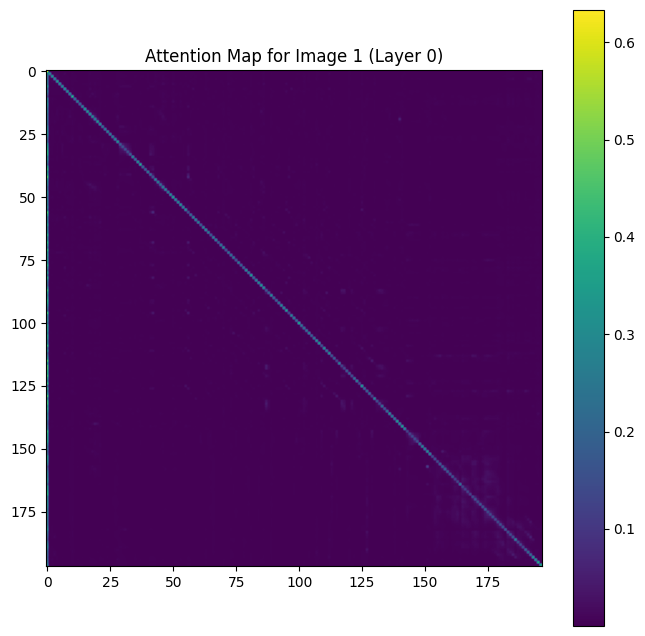

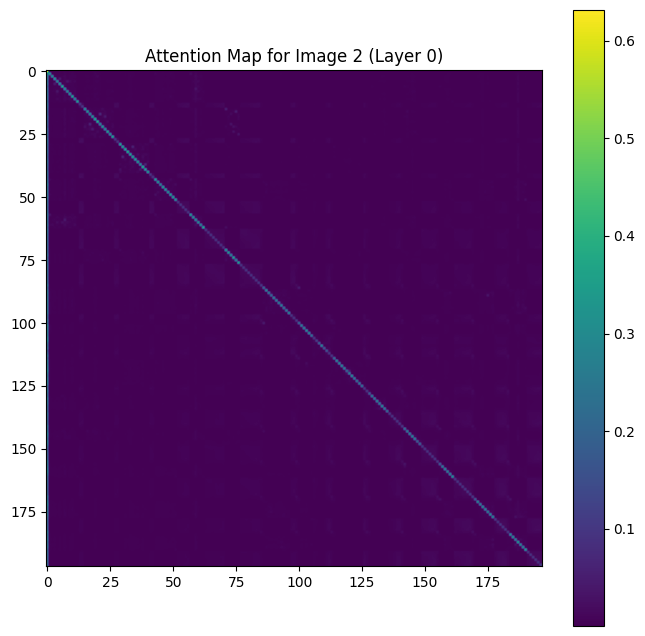

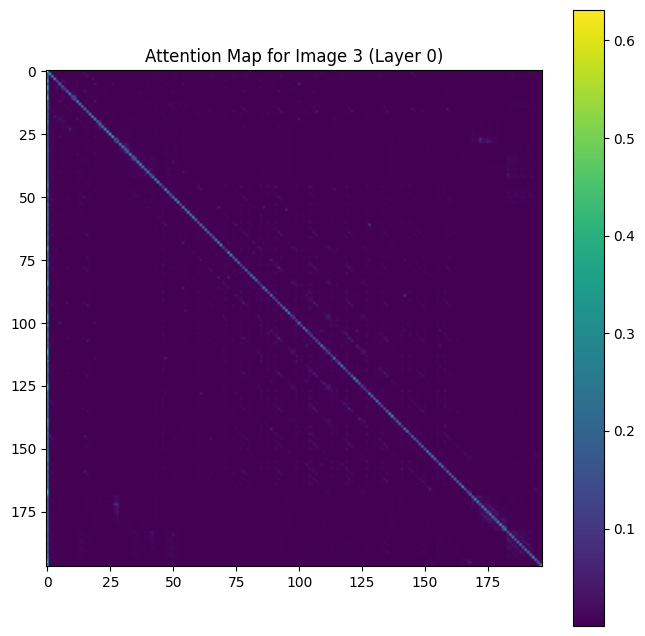

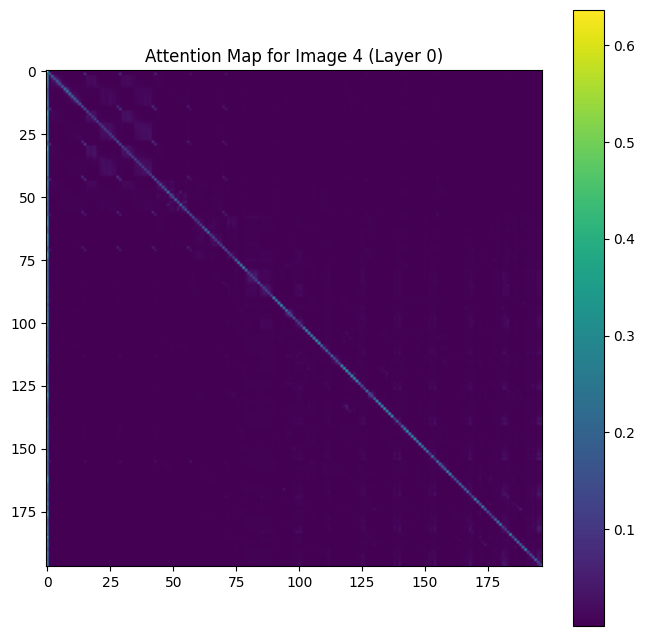

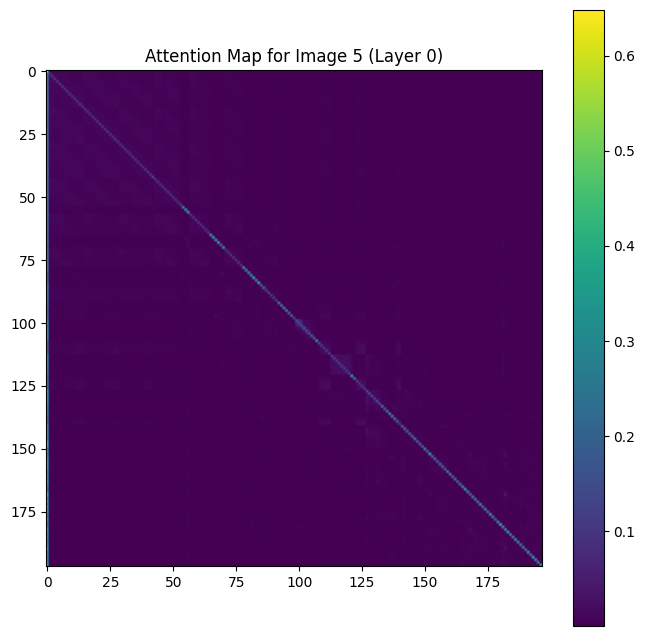

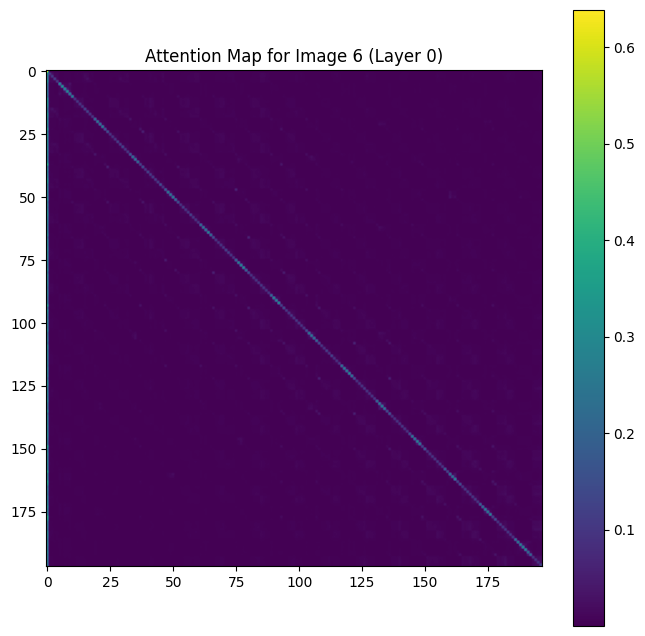

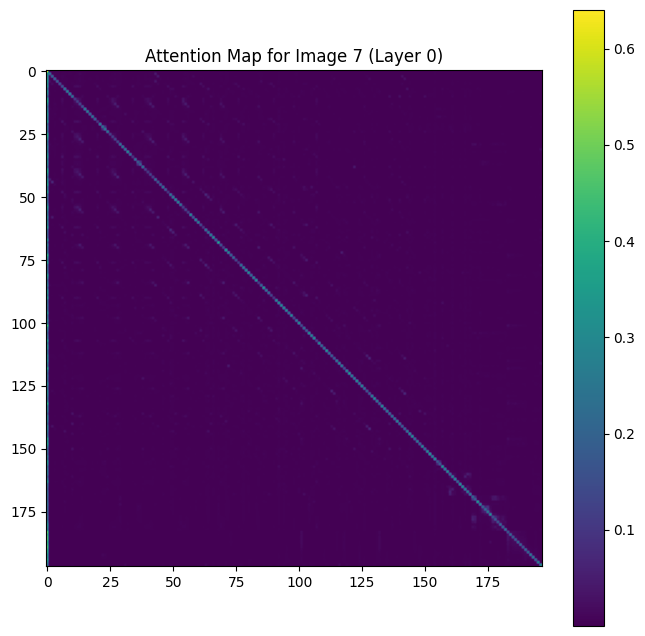

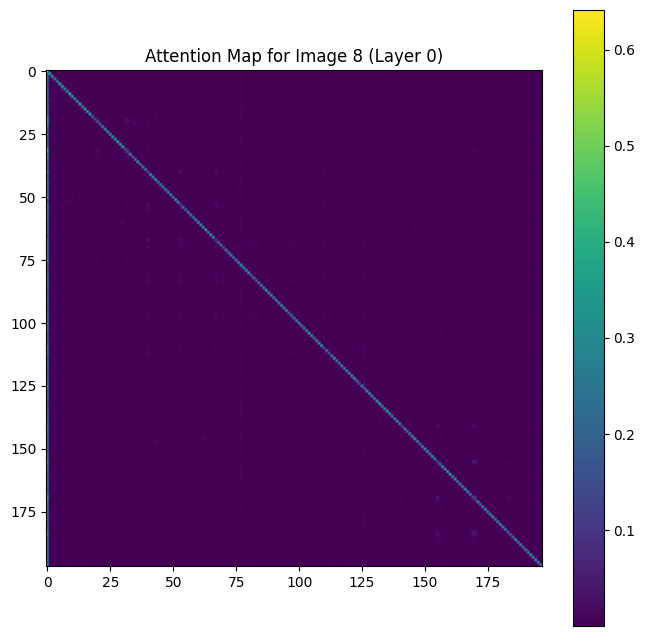

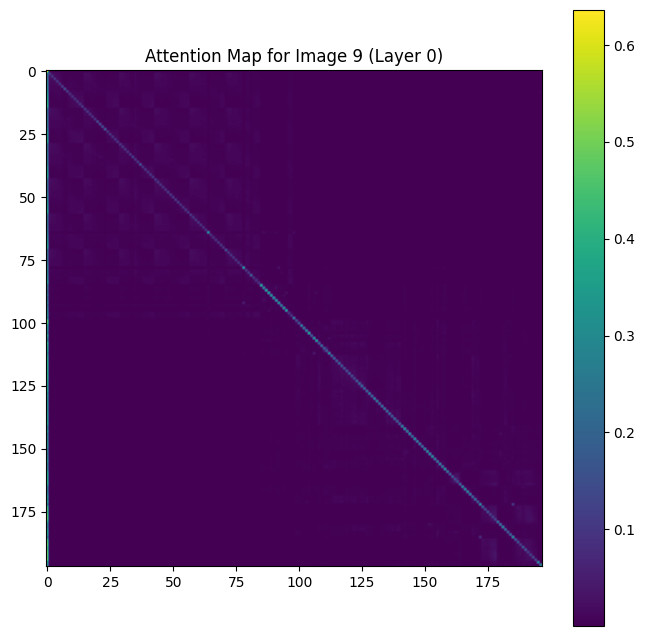

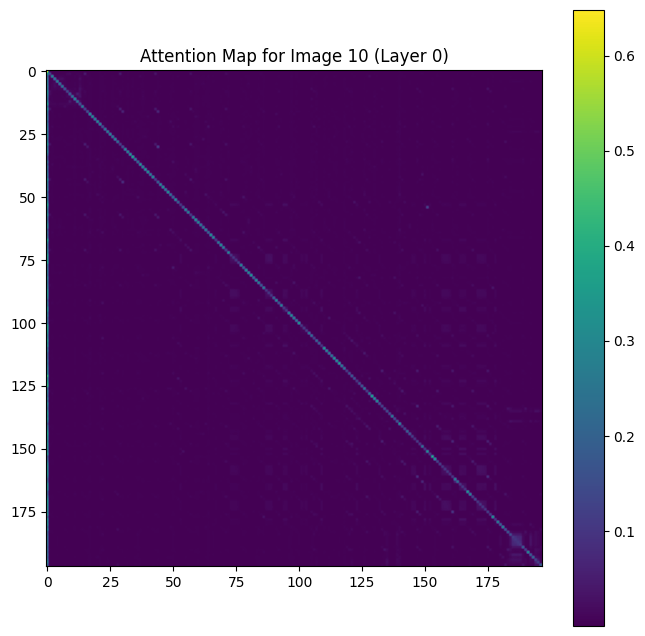

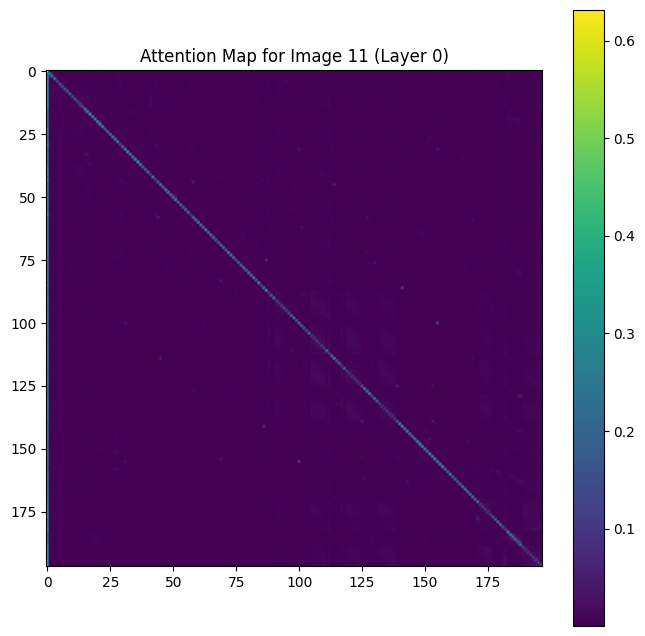

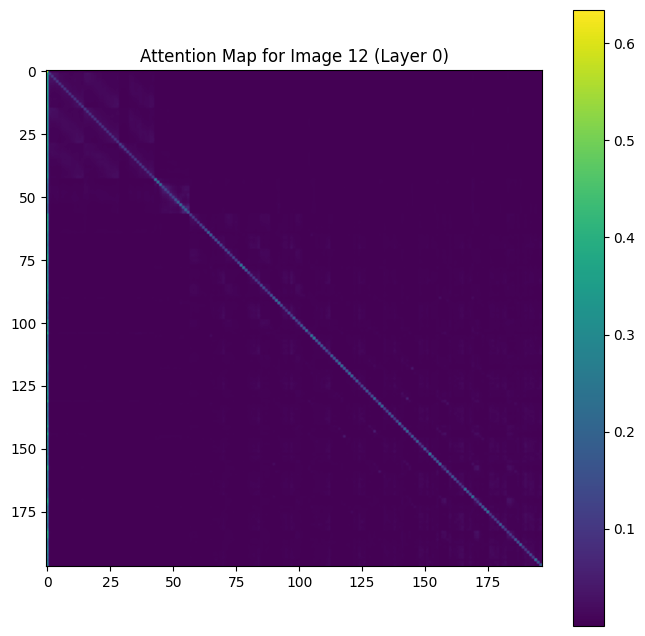

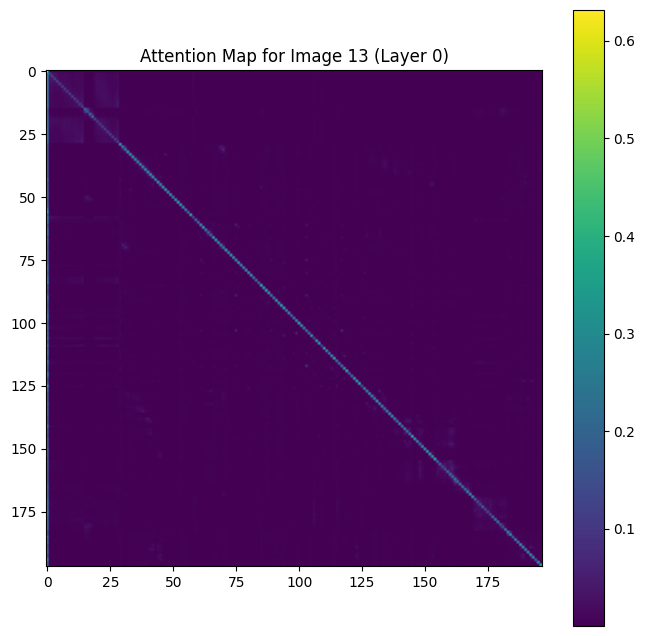

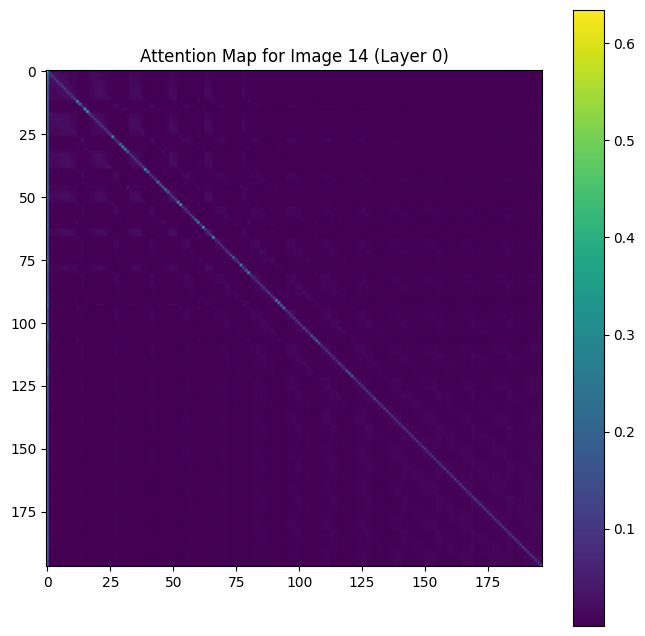

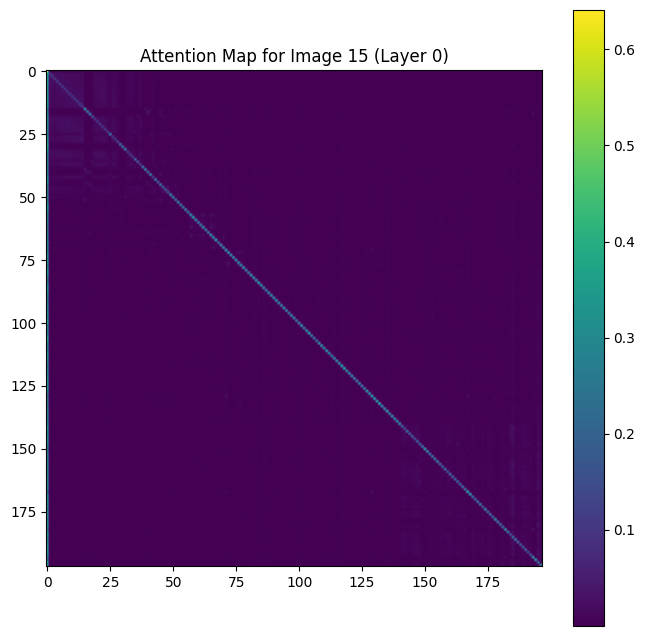

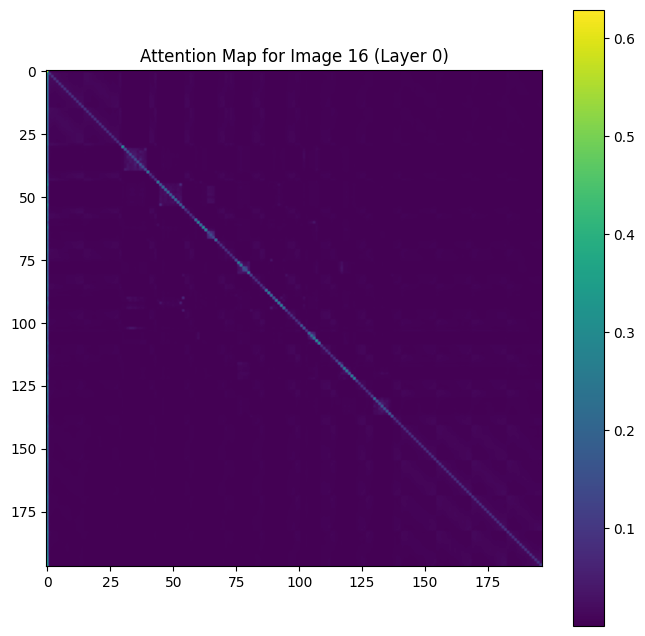

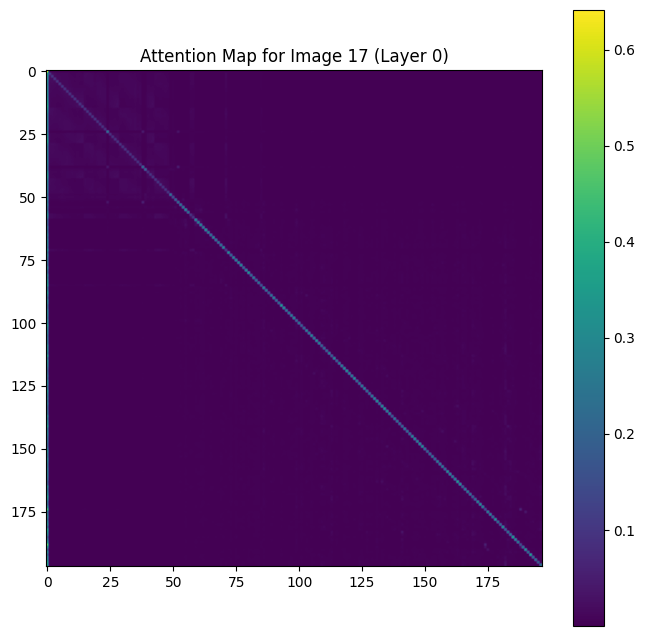

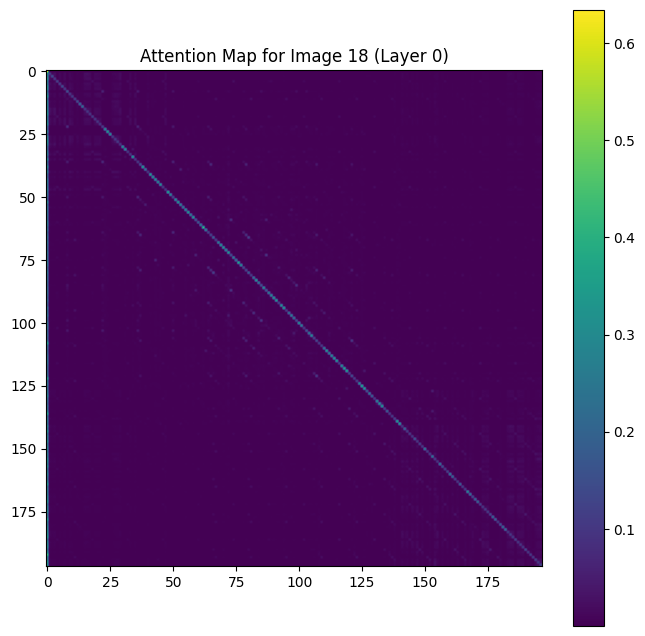

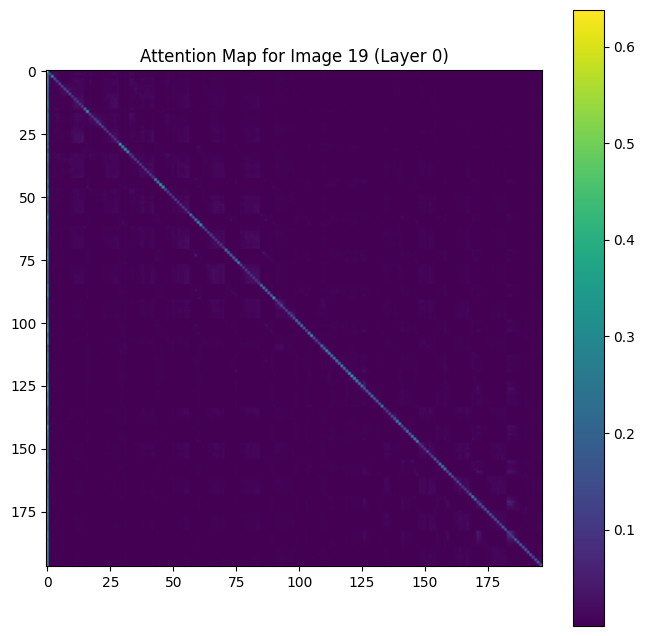

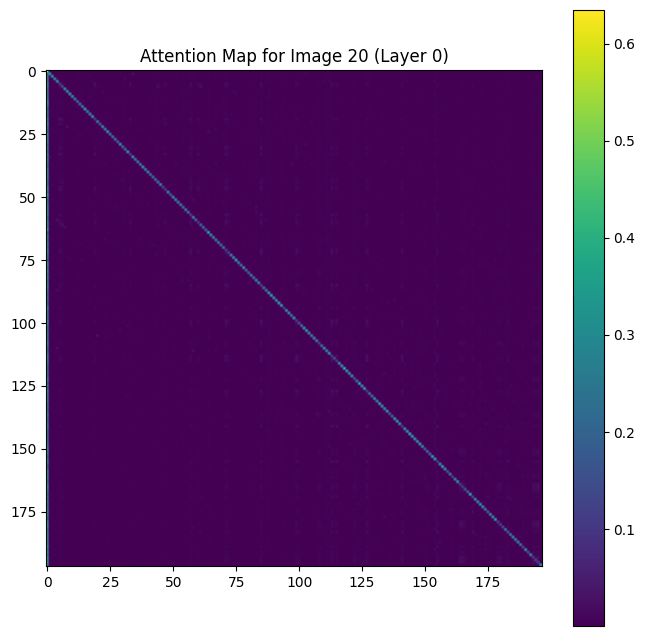

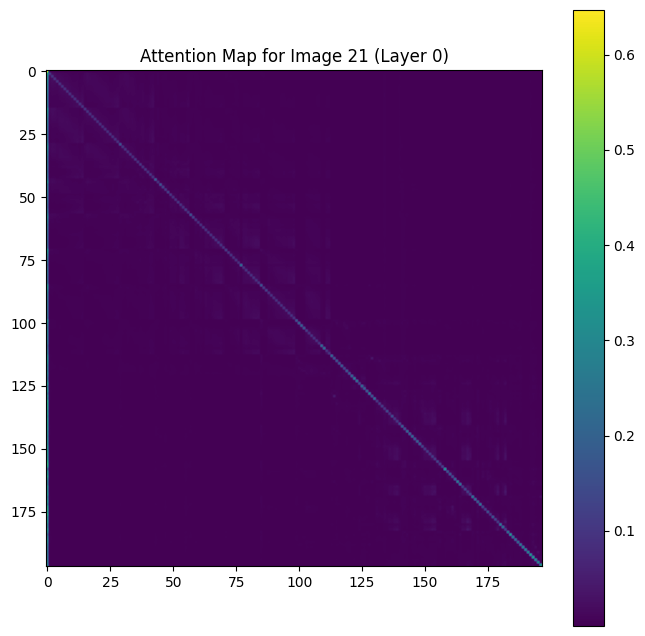

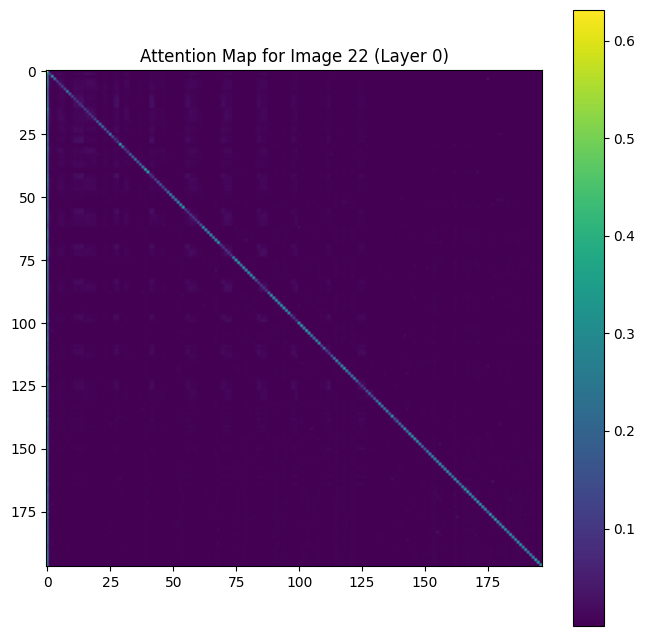

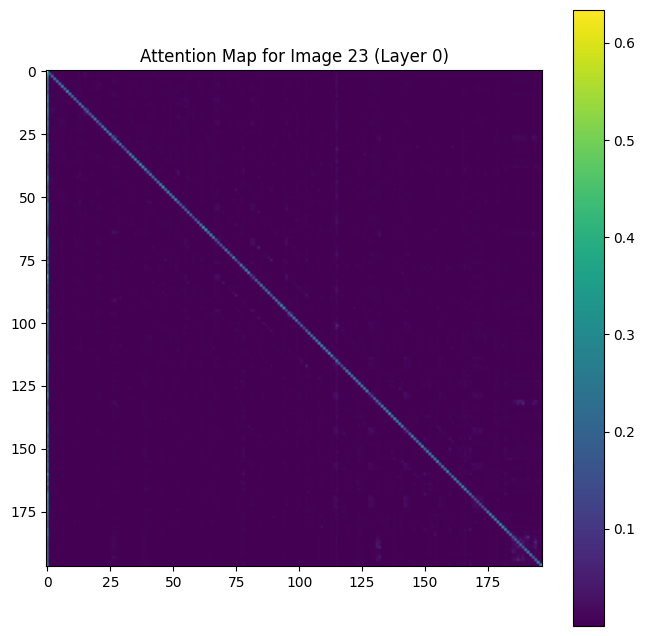

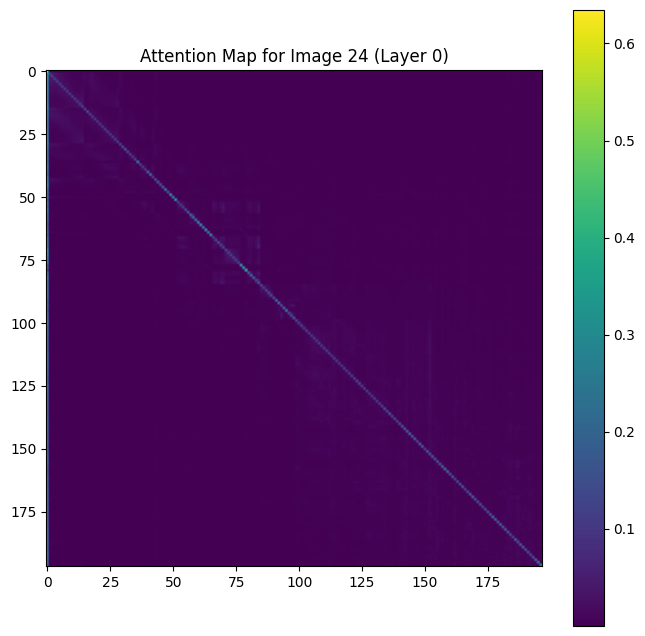

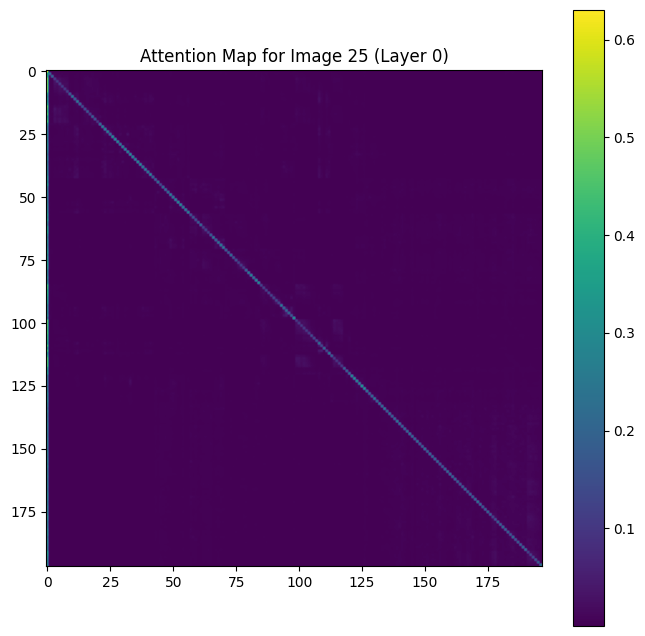

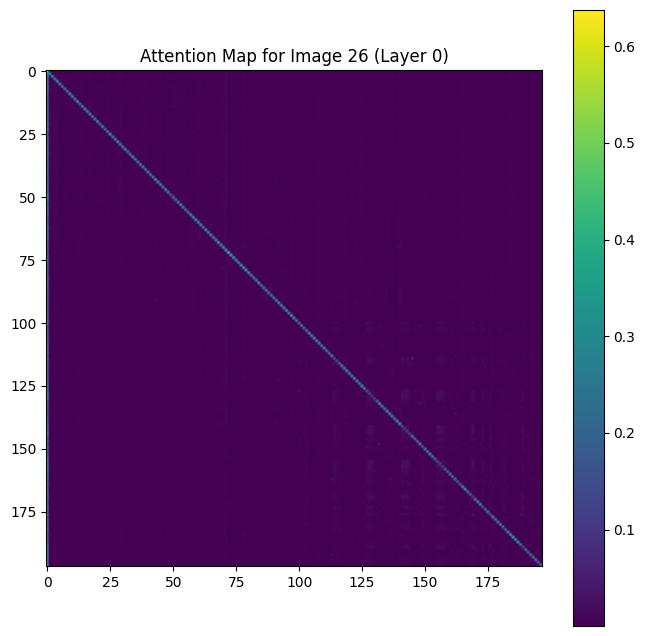

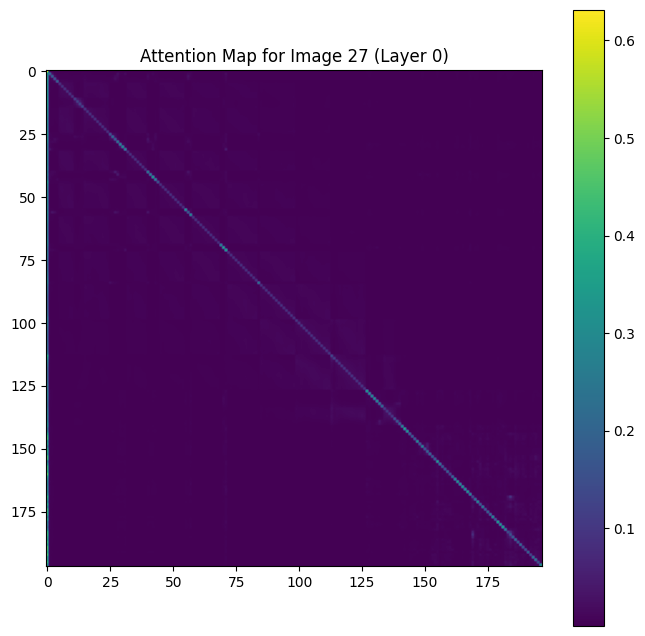

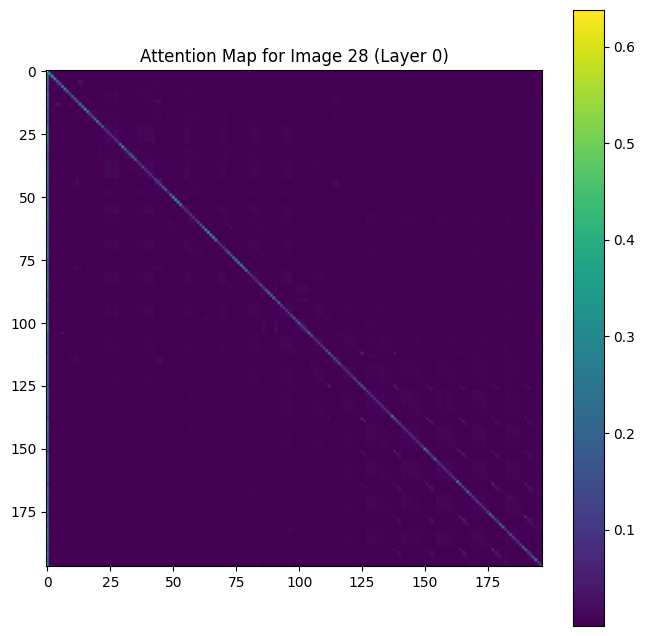

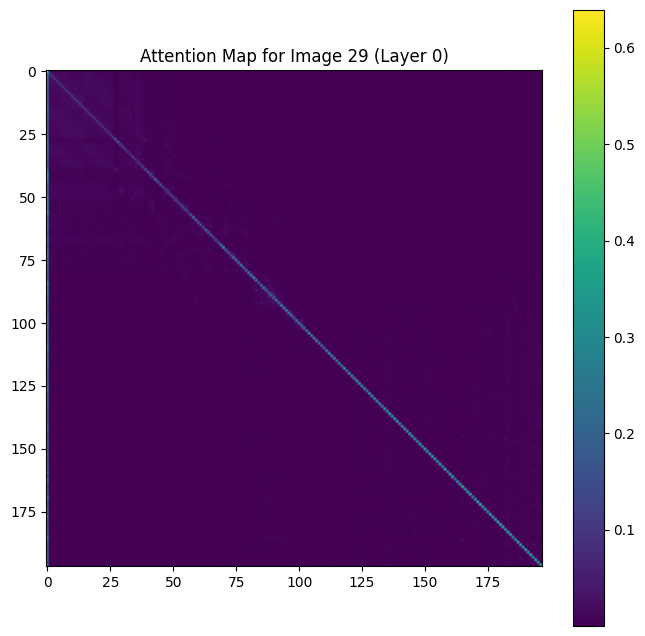

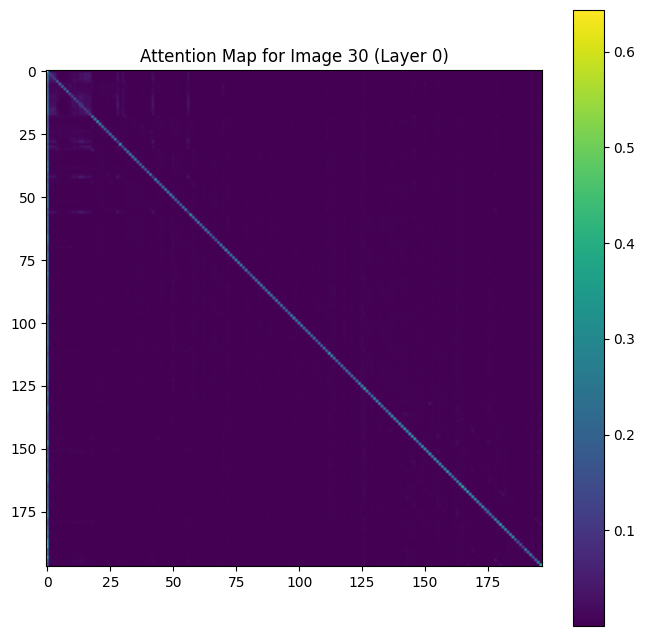

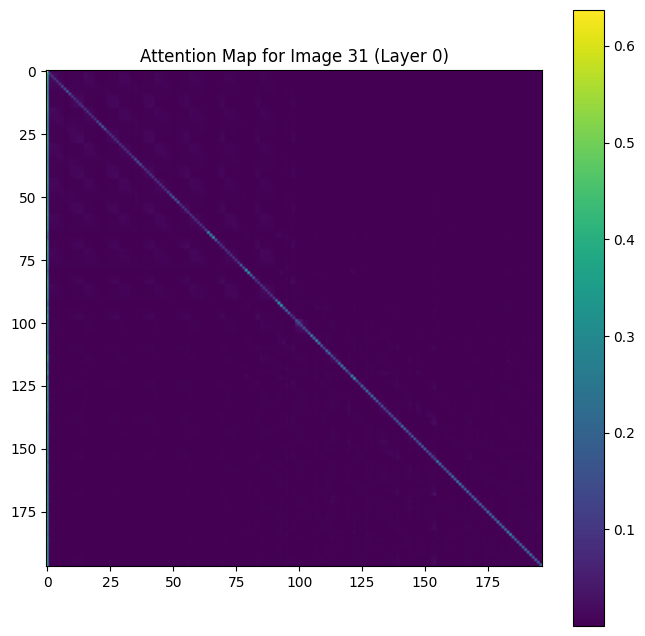

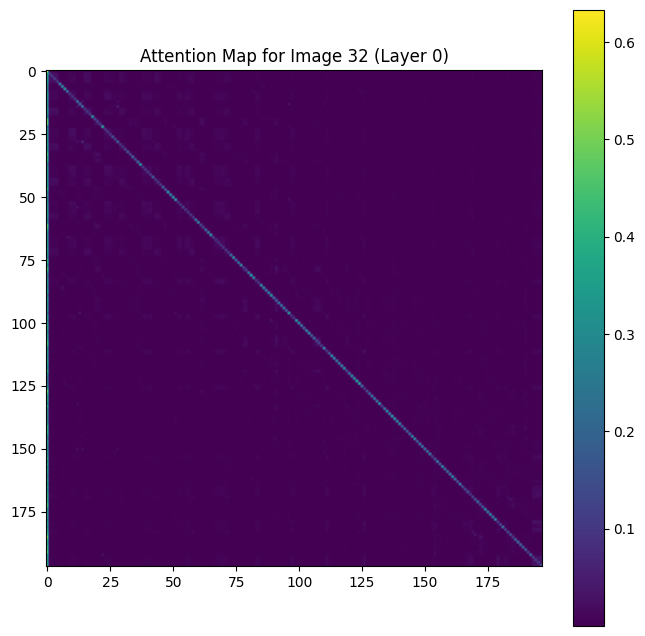

In [ ]:
# Step 3: Extract and visualize attention maps
def visualize_attention_maps(model, images, layer_idx=0):
    model.eval()
    with torch.no_grad():
        outputs = model.vit(images.to(device), output_attentions=True)
        attentions = outputs.attentions  # Extract attention maps

    # Visualize attention for the specified layer
    attention_map = attentions[layer_idx]  # Shape: [batch_size, num_heads, seq_len, seq_len]
    avg_attention = attention_map.mean(dim=1)  # Average over heads

    for i in range(images.size(0)):  # For each image in the batch
        plt.figure(figsize=(8, 8))
        plt.imshow(avg_attention[i].cpu().numpy(), cmap="viridis")
        plt.title(f"Attention Map for Image {i + 1} (Layer {layer_idx})")
        plt.colorbar()
        plt.show()

# Example usage to visualize attention
images, _ = next(iter(val_loader))  # Get a batch of validation images
visualize_attention_maps(model, images, layer_idx=0)  # Visualize attention maps for Layer 0
